<a href="https://colab.research.google.com/github/elisabethpose30/procesamientodigitaldeimagenes/blob/main/integrador_2_con_landmarks_de_google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [1]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [3]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-08 20:20:04--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-08 20:20:05--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   211MB/s    in 0.3s    

2025-05-08 20:20:05 (211 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



In [15]:
# Descargar imagen desde internet
!wget https://img.freepik.com/foto-gratis/cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552&semt=ais_hybrid&w=740




--2025-05-08 20:32:31--  https://img.freepik.com/foto-gratis/cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552
Resolving img.freepik.com (img.freepik.com)... 23.215.0.45, 23.215.0.48, 2600:1408:20::6860:dcd3, ...
Connecting to img.freepik.com (img.freepik.com)|23.215.0.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35652 (35K) [image/jpeg]
Saving to: ‘cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552’

cierrese-encima-ret 100%[===================>]  34.82K   102KB/s    in 0.3s    

2025-05-08 20:32:33 (102 KB/s) - ‘cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552’ saved [35652/35652]



In [16]:
# Verificar que se haya descargado
!ls



'cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552'
 haarcascade_frontalface_default.xml
 hombresonriendo.jpg
 lbfmodel.yaml
 sample_data


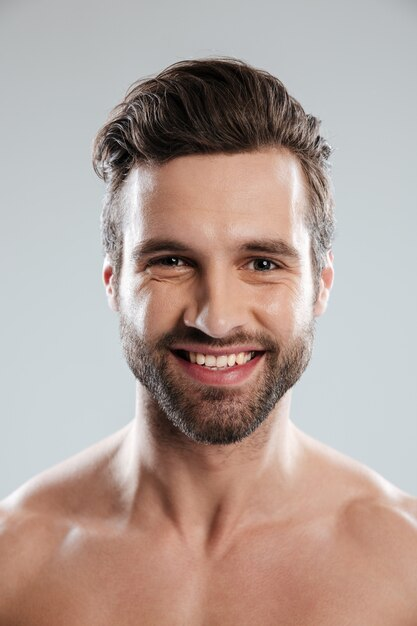

¡Imagen abierta correctamente con PIL!


In [21]:
# Intentar abrirla con PIL
from PIL import Image
from IPython.display import display

try:
    img_pil = Image.open("/content/cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552")
    display(img_pil)
    print("¡Imagen abierta correctamente con PIL!")
except Exception as e:
    print("Error al abrir la imagen con PIL:", e)



In [22]:
#Como pil trabaja con formato rgb pero el ejercicio pide abrirla con opencv la paso a bgr(open cv)
import cv2
import numpy as np

# Convertir la imagen PIL a formato OpenCV (BGR)
img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
print("Imagen convertida a OpenCV. Dimensiones:", img_cv.shape)


Imagen convertida a OpenCV. Dimensiones: (626, 417, 3)


array([[[165, 166, 168],
        [166, 167, 169],
        [166, 167, 169],
        ...,
        [168, 172, 175],
        [168, 172, 175],
        [166, 170, 173]],

       [[166, 167, 169],
        [166, 167, 169],
        [166, 167, 169],
        ...,
        [168, 172, 175],
        [168, 172, 175],
        [167, 171, 174]],

       [[166, 167, 169],
        [166, 167, 169],
        [167, 168, 170],
        ...,
        [169, 173, 176],
        [169, 173, 176],
        [168, 172, 175]],

       ...,

       [[119,  73,  50],
        [119,  73,  50],
        [121,  75,  52],
        ...,
        [177, 127, 104],
        [175, 125, 102],
        [175, 125, 100]],

       [[117,  70,  50],
        [118,  71,  51],
        [120,  73,  53],
        ...,
        [176, 124, 102],
        [174, 122, 100],
        [175, 123,  99]],

       [[116,  69,  49],
        [118,  71,  51],
        [120,  73,  53],
        ...,
        [175, 123, 101],
        [173, 121,  99],
        [174, 122,  98]]], dtype=uint8)
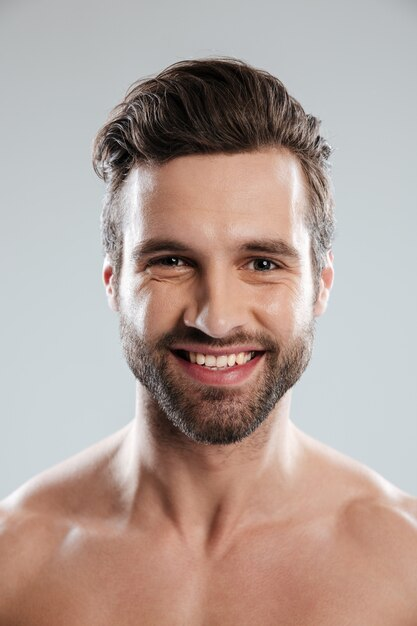

In [23]:
# y aaca la paso a rgb como pide el ejercicio
np.array(img_pil)

### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [ ]:
# Cargar la imagen original
#img = cv2.imread("../imgs/9reinas.jpg")

#if img is None:
  #print("Error al cargar la imagen '../imgs/9reinas.jpg'. Verifica la ruta.")

#else:
  #print("Imagen original cargada (formato BGR). Dimensiones:", img.shape)

## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

In [24]:
# Convertir la imagen a escala de grises
img_gray = cv2.cvtColor(np.array(img_pil), cv2.COLOR_BGR2GRAY)


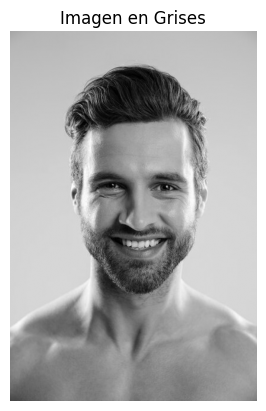

In [28]:
import matplotlib.pyplot as plt

plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title('Imagen en Grises')
plt.show()


### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

In [30]:
# Instanciamos el objeto con la definiciones relevantes a deteccion de rostros
# Como dijimos anteriormente, este "Cascade Classifier" puede usarse para detectar otro tipo de objetos
import os
if not os.path.exists("haarcascade_frontalface_default.xml"):
  !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [31]:
# Finalmente, aplicamos el detector a la imagen
faces = face_cascade.detectMultiScale(img_gray)
# Obtenemos una cara
len(faces)

1

In [32]:
# Finalmente, aplicamos el detector a la imagen
faces = face_cascade.detectMultiScale(img_gray)
# Obtenemos una cara
len(faces)

1

In [34]:
faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)
# Obtenemos una cara
len(faces)

1

In [36]:
# Assuming 'faces' contains at least one face:
if len(faces) > 0:
  x, y, w, h = faces[0]  # Access the first (and only) detected face
  print("Bounding box coordinates:", x, y, w, h)
else:
  print("No faces detected in the image.")

Bounding box coordinates: 96 170 242 242


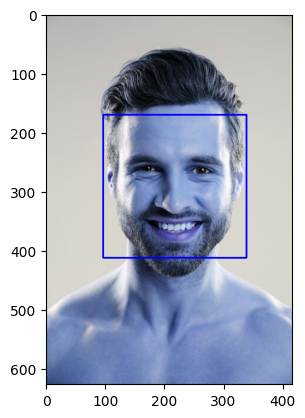

In [40]:
 # Convert the PIL Image to a NumPy array
img_np = np.array(img_pil)

# Draw the rectangle on the NumPy array
cv2.rectangle(img_np, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Display the image using Matplotlib
plt.imshow(img_np[:, :, [2, 1, 0]])

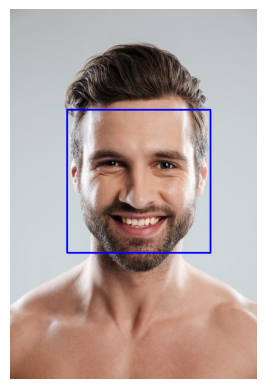

In [41]:
# Convertí la imagen PIL a array y luego a BGR ya que me mostraba la imagen en azul
img_np = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# Dibujá el rectángulo (OpenCV trabaja con BGR)
cv2.rectangle(img_np, (x, y), (x+w, y+h), (255, 0, 0), 2)  # azul en BGR

# Convertí de nuevo a RGB para mostrarla con matplotlib
img_to_show = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.axis('off')
plt.show()


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

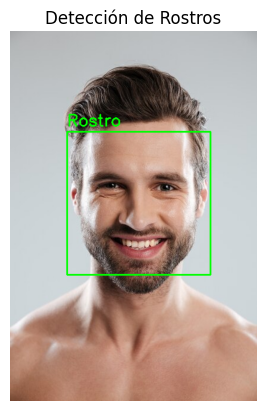

In [42]:
# Convertir imagen PIL a array RGB y luego a BGR para trabajar con OpenCV
img_np = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

# Dibujar rectángulos y etiquetas
for (x, y, w, h) in faces:
    cv2.rectangle(img_np, (x, y), (x + w, y + h), (0, 255, 0), 2)  # verde en BGR
    cv2.putText(img_np, "Rostro", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Convertir de nuevo a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detección de Rostros")
plt.show()

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [45]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, landmarks = landmark_detector.fit(img_gray, faces)


    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 1 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Pauls)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

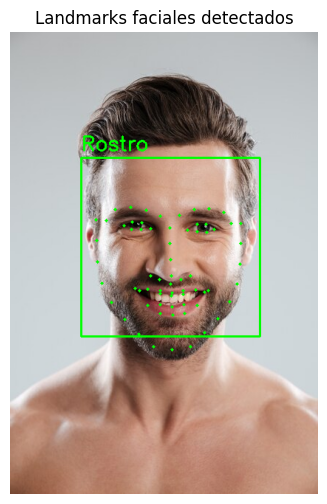

In [46]:
# Dibujo de landmarks sobre la imagen original
if all_landmarks is not None:
    for i in range(len(faces)):
        for (x, y) in all_landmarks[i][0]:  # Extraemos los puntos del primer nivel
            cv2.circle(img_np, (int(x), int(y)), 2, (0, 255, 0), -1)  # punto verde
else:
    print("No hay landmarks para mostrar.")

# Convertimos la imagen de BGR a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

# Mostramos la imagen
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Landmarks faciales detectados")
plt.show()


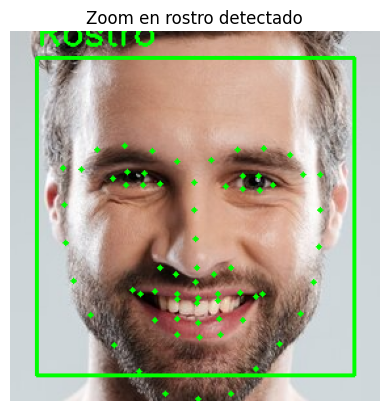

In [48]:
#zoom de la imagen

# Verificamos que haya al menos una cara
if len(faces) > 0:
    x, y, w, h = faces[0]

    # Definimos márgenes para hacer un zoom más amplio
    margen = 20
    x1 = max(x - margen, 0)
    y1 = max(y - margen, 0)
    x2 = min(x + w + margen, img_rgb.shape[1])
    y2 = min(y + h + margen, img_rgb.shape[0])

    # Mostramos el recorte (zoom)
    plt.figure()
    plt.imshow(img_rgb[y1:y2, x1:x2])
    plt.title("Zoom en rostro detectado")
    plt.axis('off')
    plt.show()
else:
    print("No se detectó ningún rostro para hacer zoom.")


### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

In [ ]:
# Solución Ejercicio 5 (Procesar y dibujar landmarks Darín)

#if all_landmarks is not None and len(all_landmarks) >= 2:
  # Procesar landmarks Darín (indice 1)
  #landmarks_darin = all_landmarks[1]
  #landmarks_darin = landmarks_darin[0].astype(int)
  #print("Landmarks Darín procesados. Forma:", landmarks_darin.shape)

  # Dibujar sobre la imagen 'img_rgb' existente
  #print("\nDibujando landmarks de Darín (rojo):")
  #for x, y in landmarks_darin:
      #cv2.circle(img_rgb, (x, y), 0, (255, 0, 0), 1)
  #plt.imshow(img_rgb)
  #plt.title("Rostros + Ambos Landmarks")

  # Mostrar zoom
  #print("\nZoom en Darín:")
  #plt.figure()
  #plt.imshow(img_rgb[70:150, 130:190])
  #plt.title("Zoom Landmarks Darín")

#elif all_landmarks is None:
  #print("No hay landmarks disponibles.")
#elif len(all_landmarks) < 2:
  #print("Solo se detectó 1 rostro, no se pueden procesar landmarks para Darín.")

## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre ` all_landmarks`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

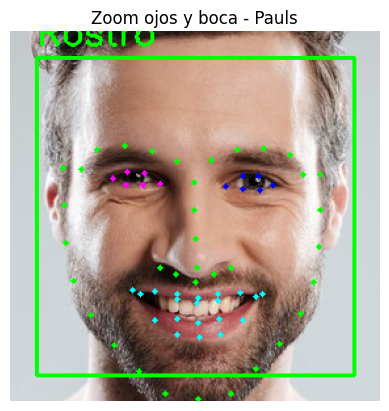

In [49]:
#Los landmarks se organizan así (para una cara):
#Ojo derecho: índices 36 a 41
#Ojo izquierdo: índices 42 a 47
#Boca: índices 48 a 67

# Índices para los ojos y la boca
ojo_derecho = list(range(36, 42))
ojo_izquierdo = list(range(42, 48))
boca = list(range(48, 68))

# Creamos una copia de la imagen en RGB para visualizar
img_con_partes = cv2.cvtColor(img_np.copy(), cv2.COLOR_BGR2RGB)

# Dibujamos solo los puntos de ojos y boca (asumimos que usamos la primera cara)
if all_landmarks is not None and len(all_landmarks) > 0:
    puntos = all_landmarks[0][0]  # Sacamos los landmarks de la primera cara

    for i in ojo_derecho:
        x, y = puntos[i]
        cv2.circle(img_con_partes, (int(x), int(y)), 2, (255, 0, 255), -1)  # Magenta

    for i in ojo_izquierdo:
        x, y = puntos[i]
        cv2.circle(img_con_partes, (int(x), int(y)), 2, (0, 0, 255), -1)  # Azul

    for i in boca:
        x, y = puntos[i]
        cv2.circle(img_con_partes, (int(x), int(y)), 2, (0, 255, 255), -1)  # Cian
else:
    print("No se encontraron landmarks.")

# Mostrar zoom en el rostro (Pauls)
if len(faces) > 0:
    x, y, w, h = faces[0]
    margen = 20
    x1 = max(x - margen, 0)
    y1 = max(y - margen, 0)
    x2 = min(x + w + margen, img_con_partes.shape[1])
    y2 = min(y + h + margen, img_con_partes.shape[0])

    plt.figure()
    plt.imshow(img_con_partes[y1:y2, x1:x2])
    plt.title("Zoom ojos y boca - Pauls")
    plt.axis('off')
    plt.show()
else:
    print("No se detectó rostro para el zoom.")


## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.

#AHORA VOY A USAR LANDMARKS FACIALES DE GOOGLE

In [50]:
# Instalamos mediapipe (generalmente ya está instalado en Colab)
# La exclamación al principio indica que es un comando de terminal
!pip install --upgrade numpy
!pip install mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [5]:
from PIL import Image
import numpy as np

# Ruta o nombre del archivo (ajustá si lo subiste a Colab)
img_pil = Image.open("/content/cierrese-encima-retrato-hombre-barbudo-joven-sonriente_171337-17189.jpg?ga=GA1.1.1245244613.1746660552")

# Convertir a NumPy
img_rgb = np.array(img_pil)  # MediaPipe usa RGB


In [6]:
# Importamos las bibliotecas que vamos a usar
import cv2 # Para manejar imágenes (leer, mostrar, dibujar)
import mediapipe as mp # La biblioteca que hace la magia de encontrar los puntos
# Esta es una función especial para mostrar imágenes en Google Colab
from google.colab.patches import cv2_imshow

print("Bibliotecas importadas correctamente.")

Bibliotecas importadas correctamente.


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp


In [8]:
# Convertí la imagen PIL a formato NumPy (si no lo hiciste ya)
img_rgb = np.array(img_pil)  # RGB porque PIL abre en RGB
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# Instanciamos FaceMesh de mediapipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)


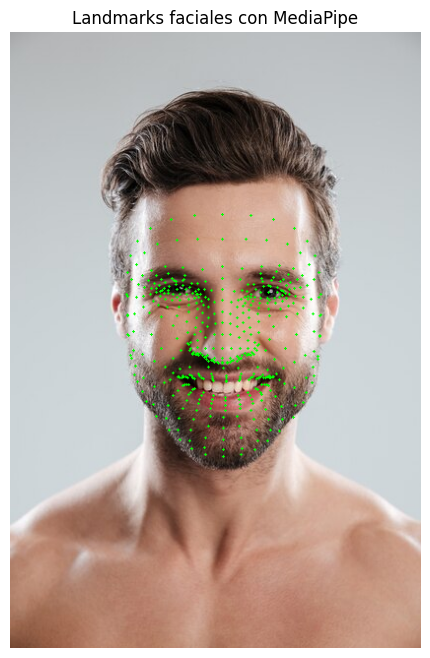

In [9]:
# Procesar la imagen
results = face_mesh.process(img_rgb)

# Dibujamos resultados si se detectaron landmarks
if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Dibuja los landmarks sobre una copia de la imagen original
        img_landmarks = img_rgb.copy()

        # Dibujamos cada punto
        for i, landmark in enumerate(face_landmarks.landmark):
            h, w, _ = img_rgb.shape
            x = int(landmark.x * w)
            y = int(landmark.y * h)
            cv2.circle(img_landmarks, (x, y), 1, (0, 255, 0), -1)

    # Mostrar la imagen con landmarks
    plt.figure(figsize=(8, 8))
    plt.imshow(img_landmarks)
    plt.title("Landmarks faciales con MediaPipe")
    plt.axis('off')
    plt.show()
else:
    print("No se detectaron caras con MediaPipe.")


#Esto detecta 468 puntos por cara con una precisión muy alta (ojos, boca, nariz, mandíbula, etc.).

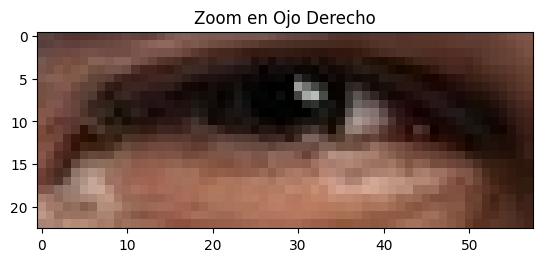

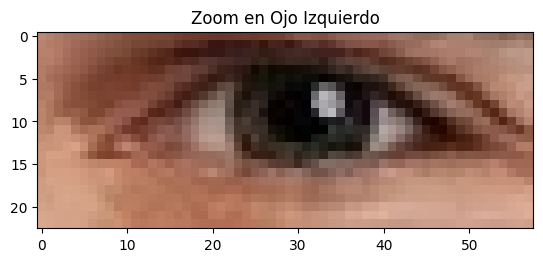

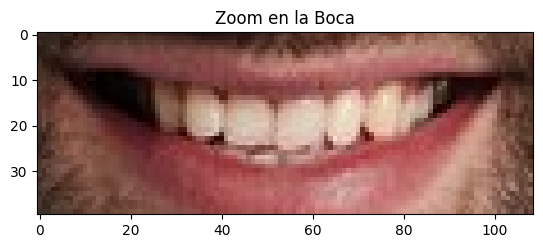

In [12]:
#HACEMOS ZOOM DE OJOS Y BOCA

# Iniciamos FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# Detectamos landmarks
results = face_mesh.process(img_rgb)

# Verificamos si se detectó una cara
if results.multi_face_landmarks:
    face_landmarks = results.multi_face_landmarks[0]

    # Convertimos las coordenadas normalizadas a píxeles
    h, w, _ = img_rgb.shape
    landmark_coords = [(int(pt.x * w), int(pt.y * h)) for pt in face_landmarks.landmark]

    # Extraemos puntos clave de ojos y boca (según el índice del modelo de MediaPipe)
    # Referencia oficial: https://github.com/google/mediapipe/blob/master/mediapipe/python/solutions/face_mesh_connections.py

    # OJO DERECHO (ej: 33, 133)
    right_eye_indices = [33, 133]
    # OJO IZQUIERDO (ej: 362, 263)
    left_eye_indices = [362, 263]
    # BOCA (ej: 13, 14, 78, 308)
    mouth_indices = [13, 14, 78, 308]

    # Obtener bounding boxes para zoom
    def get_bbox(indices):
        x_vals = [landmark_coords[i][0] for i in indices]
        y_vals = [landmark_coords[i][1] for i in indices]
        x_min, x_max = min(x_vals), max(x_vals)
        y_min, y_max = min(y_vals), max(y_vals)
        padding = 10  # Zoom con espacio
        return slice(max(y_min - padding, 0), y_max + padding), slice(max(x_min - padding, 0), x_max + padding)

    # Mostrar zoom en ojo derecho
    eye_r_box = get_bbox(right_eye_indices)
    plt.figure()
    plt.imshow(img_rgb[eye_r_box])
    plt.title("Zoom en Ojo Derecho")

    # Mostrar zoom en ojo izquierdo
    eye_l_box = get_bbox(left_eye_indices)
    plt.figure()
    plt.imshow(img_rgb[eye_l_box])
    plt.title("Zoom en Ojo Izquierdo")

    # Mostrar zoom en la boca
    mouth_box = get_bbox(mouth_indices)
    plt.figure()
    plt.imshow(img_rgb[mouth_box])
    plt.title("Zoom en la Boca")

    plt.show()

else:
    print("No se detectaron rostros.")
